In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [10]:
df = df.loc[df.date >= '2022-01-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

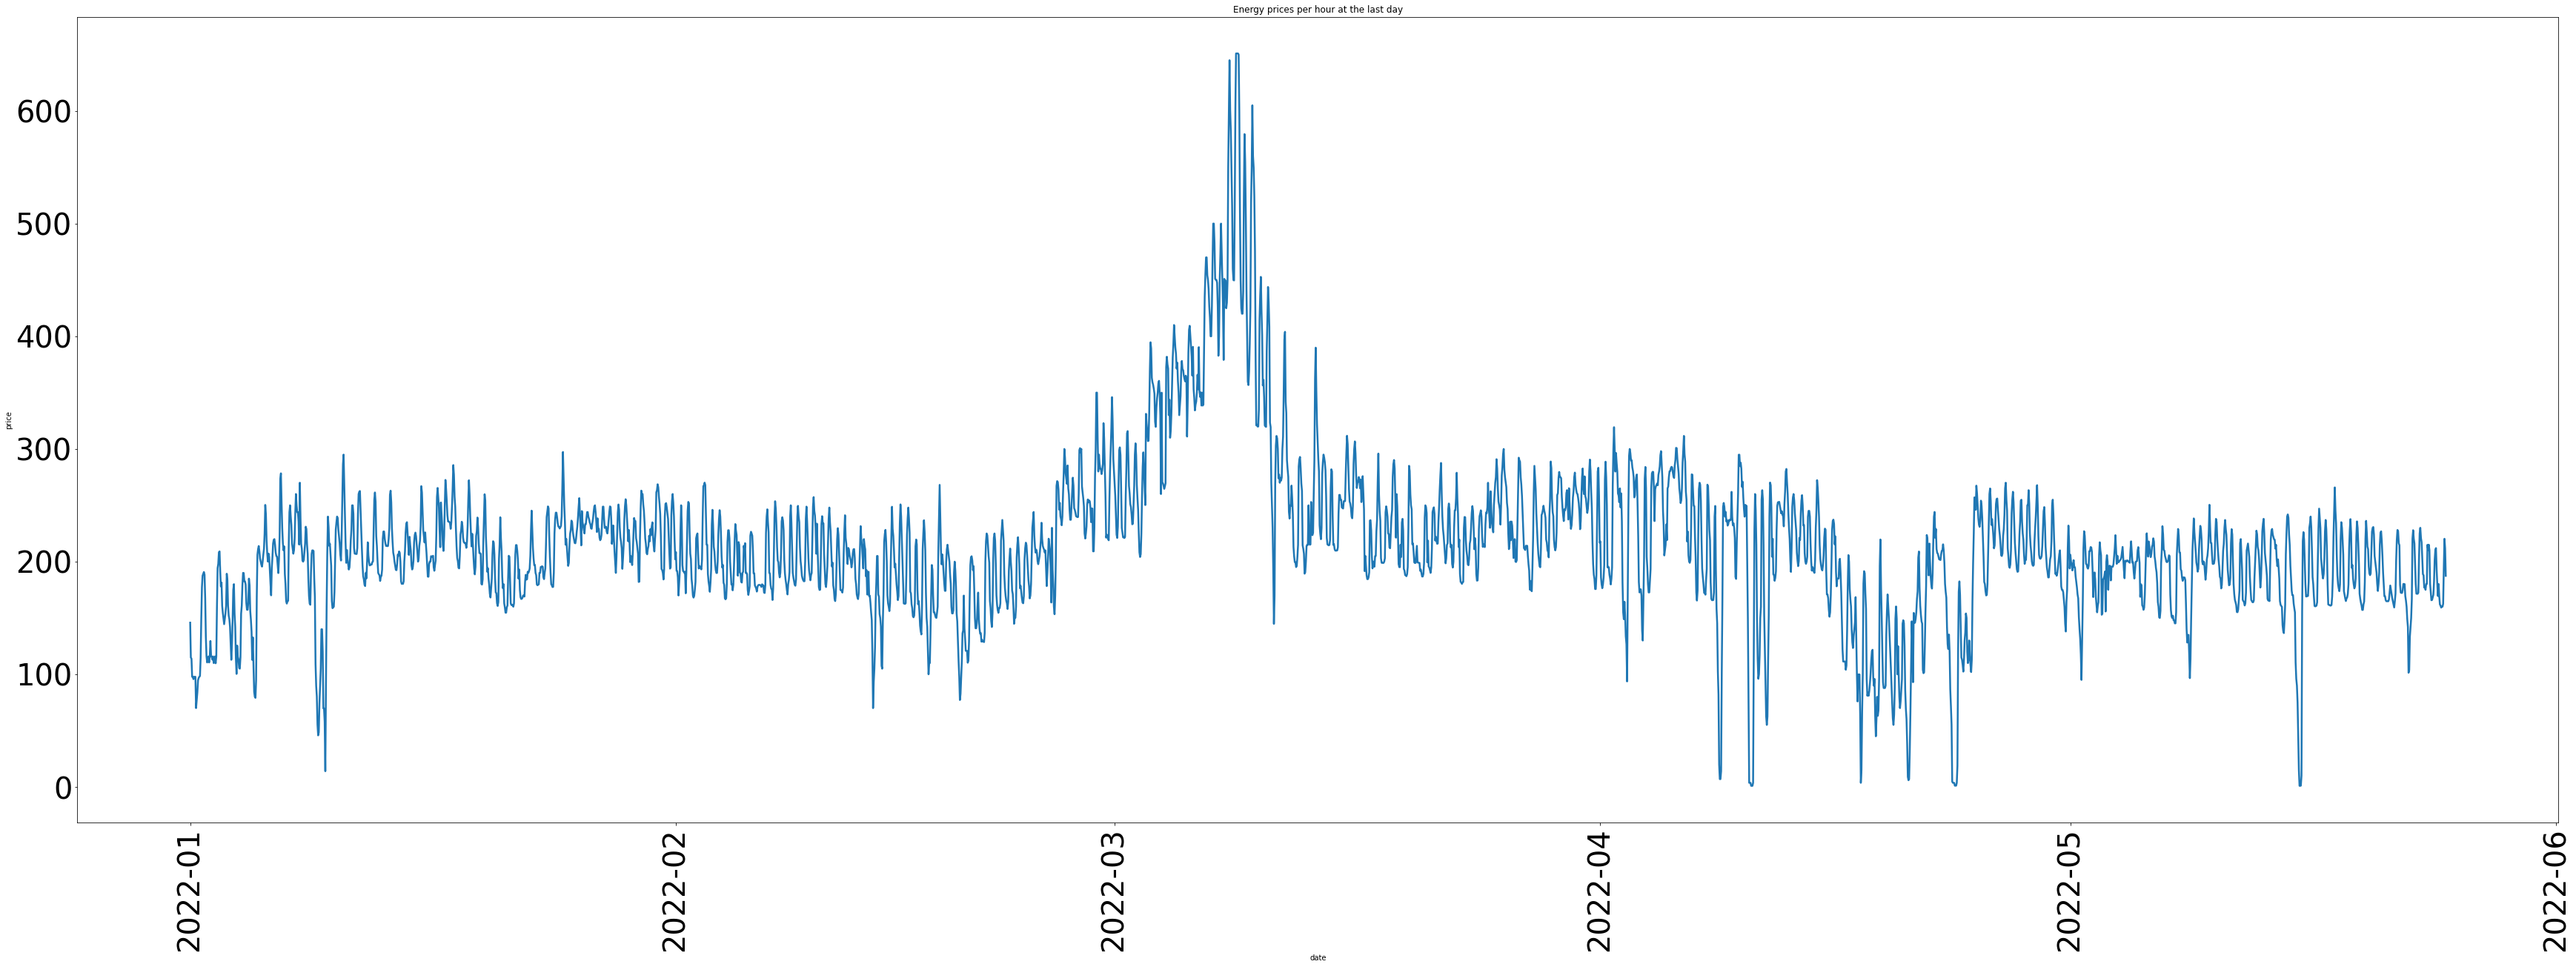

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 40)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [15]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana (Probamos 5)
w_size = 5 
#Número de entradas
n_inputs = len(df.columns)

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple(df, w_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir nuestra ventana simple
    for i in range(len(df_as_np) - w_size):
        row = [r for r in df_as_np[i:i + w_size]]
        x.append(row)
        
        #Solo queremos el precio
        label = df_as_np[i + w_size][0]
        y.append(label)
    
    y_array = np.array(y)
    return np.array(x), y_array.reshape((y_array.size,1))

In [17]:
x, y = df_to_x_y_multiple(df, w_size)
x.shape, y.shape

((3450, 5, 7), (3450, 1))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2415, 5, 7), (2415, 1), (693, 5, 7), (693, 1), (342, 5, 7), (342, 1))

In [20]:
x_mean = np.mean(x[:, :, 0])
x_std = np.std(x[:, :, 0])
y_mean = np.mean(y[:, 0])
y_std = np.std(y[:, 0])

In [21]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:, 0] = (df[:, 0] - y_mean) / y_std
    return df

In [22]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)


In [23]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [24]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
def build_model_lstm_unrestricted():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [30]:
def build_model_lstm_dropout():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [31]:
def build_model_lstm_go_bwd():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, go_backwards = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [32]:
def build_model_lstm_bidirectional():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [33]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()
model_lstm_unrestricted = build_model_lstm_unrestricted()
model_lstm_dropout = build_model_lstm_dropout()
model_lstm_go_bwd = build_model_lstm_go_bwd()
model_lstm_bi = build_model_lstm_bidirectional()

2022-06-08 13:37:47.073616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 13:37:48.091884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21240 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-08 13:37:48.093025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26742 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [35]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500


2022-06-08 13:37:51.577967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


76/76 [==============================] - 3s 12ms/step - loss: 0.7061 - mae: 0.5331 - mse: 0.7061 - val_loss: 0.2346 - val_mae: 0.3628 - val_mse: 0.2346
Epoch 2/500
76/76 [==============================] - 1s 8ms/step - loss: 0.2610 - mae: 0.3434 - mse: 0.2610 - val_loss: 0.1267 - val_mae: 0.2307 - val_mse: 0.1267
Epoch 3/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1770 - mae: 0.2959 - mse: 0.1770 - val_loss: 0.1148 - val_mae: 0.2247 - val_mse: 0.1148
Epoch 4/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1577 - mae: 0.2753 - mse: 0.1577 - val_loss: 0.0966 - val_mae: 0.2151 - val_mse: 0.0966
Epoch 5/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1400 - mae: 0.2592 - mse: 0.1400 - val_loss: 0.0892 - val_mae: 0.2109 - val_mse: 0.0892
Epoch 6/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1213 - mae: 0.2432 - mse: 0.1213 - val_loss: 0.0871 - val_mae: 0.2145 - val_mse: 0.0871
Epoch 7/500
76/76 [==============

In [36]:
history_lstm_ret_seq = model_lstm_ret_seq.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 3s 18ms/step - loss: 0.7874 - mae: 0.5761 - mse: 0.7874 - val_loss: 0.2482 - val_mae: 0.3854 - val_mse: 0.2482
Epoch 2/500
76/76 [==============================] - 1s 11ms/step - loss: 0.3657 - mae: 0.4228 - mse: 0.3657 - val_loss: 0.1861 - val_mae: 0.2931 - val_mse: 0.1861
Epoch 3/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2385 - mae: 0.3486 - mse: 0.2385 - val_loss: 0.1348 - val_mae: 0.2362 - val_mse: 0.1348
Epoch 4/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1908 - mae: 0.3121 - mse: 0.1908 - val_loss: 0.1161 - val_mae: 0.2398 - val_mse: 0.1161
Epoch 5/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1705 - mae: 0.2924 - mse: 0.1705 - val_loss: 0.1036 - val_mae: 0.2461 - val_mse: 0.1036
Epoch 6/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1606 - mae: 0.2878 - mse: 0.1606 - val_loss: 0.0972 - val_mae: 0.2336 - val_mse: 0.0972
Epoch 7/500
76/7

In [37]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 1s 8ms/step - loss: 0.5501 - mae: 0.4983 - mse: 0.5501 - val_loss: 0.1157 - val_mae: 0.2453 - val_mse: 0.1157
Epoch 2/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1471 - mae: 0.2659 - mse: 0.1471 - val_loss: 0.0634 - val_mae: 0.1798 - val_mse: 0.0634
Epoch 3/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1175 - mae: 0.2403 - mse: 0.1175 - val_loss: 0.0627 - val_mae: 0.1903 - val_mse: 0.0627
Epoch 4/500
76/76 [==============================] - 0s 6ms/step - loss: 0.0989 - mae: 0.2198 - mse: 0.0989 - val_loss: 0.0617 - val_mae: 0.1948 - val_mse: 0.0617
Epoch 5/500
76/76 [==============================] - 0s 6ms/step - loss: 0.0875 - mae: 0.2091 - mse: 0.0875 - val_loss: 0.0642 - val_mae: 0.1968 - val_mse: 0.0642
Epoch 6/500
76/76 [==============================] - 0s 6ms/step - loss: 0.0823 - mae: 0.2048 - mse: 0.0823 - val_loss: 0.0625 - val_mae: 0.1933 - val_mse: 0.0625
Epoch 7/500
76/76 [===

In [38]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 1s 7ms/step - loss: 0.7676 - mae: 0.5674 - mse: 0.7676 - val_loss: 0.2002 - val_mae: 0.3666 - val_mse: 0.2002
Epoch 2/500
76/76 [==============================] - 0s 6ms/step - loss: 0.3138 - mae: 0.3580 - mse: 0.3138 - val_loss: 0.0872 - val_mae: 0.2214 - val_mse: 0.0872
Epoch 3/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1521 - mae: 0.2638 - mse: 0.1521 - val_loss: 0.0662 - val_mae: 0.1995 - val_mse: 0.0662
Epoch 4/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1158 - mae: 0.2340 - mse: 0.1158 - val_loss: 0.0621 - val_mae: 0.1914 - val_mse: 0.0621
Epoch 5/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1003 - mae: 0.2211 - mse: 0.1003 - val_loss: 0.0651 - val_mae: 0.1948 - val_mse: 0.0651
Epoch 6/500
76/76 [==============================] - 0s 6ms/step - loss: 0.0913 - mae: 0.2123 - mse: 0.0913 - val_loss: 0.0641 - val_mae: 0.1939 - val_mse: 0.0641
Epoch 7/500
76/76 [===

In [39]:
history_gru = model_gru.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 2s 12ms/step - loss: 0.8235 - mae: 0.5510 - mse: 0.8235 - val_loss: 0.1540 - val_mae: 0.3136 - val_mse: 0.1540
Epoch 2/500
76/76 [==============================] - 1s 8ms/step - loss: 0.3553 - mae: 0.3745 - mse: 0.3553 - val_loss: 0.1092 - val_mae: 0.2366 - val_mse: 0.1092
Epoch 3/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1715 - mae: 0.2813 - mse: 0.1715 - val_loss: 0.0792 - val_mae: 0.1982 - val_mse: 0.0792
Epoch 4/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1240 - mae: 0.2474 - mse: 0.1240 - val_loss: 0.0648 - val_mae: 0.1914 - val_mse: 0.0648
Epoch 5/500
76/76 [==============================] - 1s 8ms/step - loss: 0.1015 - mae: 0.2227 - mse: 0.1015 - val_loss: 0.0615 - val_mae: 0.1843 - val_mse: 0.0615
Epoch 6/500
76/76 [==============================] - 1s 8ms/step - loss: 0.0870 - mae: 0.2081 - mse: 0.0870 - val_loss: 0.0579 - val_mae: 0.1823 - val_mse: 0.0579
Epoch 7/500
76/76 [==

In [40]:
history_lstm_unrestricted = model_lstm_unrestricted.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 3s 18ms/step - loss: 0.7514 - mae: 0.5869 - mse: 0.7514 - val_loss: 0.2755 - val_mae: 0.4225 - val_mse: 0.2755
Epoch 2/500
76/76 [==============================] - 1s 11ms/step - loss: 0.4529 - mae: 0.4802 - mse: 0.4529 - val_loss: 0.2150 - val_mae: 0.3468 - val_mse: 0.2150
Epoch 3/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2811 - mae: 0.3802 - mse: 0.2811 - val_loss: 0.1454 - val_mae: 0.2631 - val_mse: 0.1454
Epoch 4/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2132 - mae: 0.3298 - mse: 0.2132 - val_loss: 0.1589 - val_mae: 0.2785 - val_mse: 0.1589
Epoch 5/500
76/76 [==============================] - 1s 10ms/step - loss: 0.2195 - mae: 0.3346 - mse: 0.2195 - val_loss: 0.1139 - val_mae: 0.2242 - val_mse: 0.1139
Epoch 6/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1931 - mae: 0.3139 - mse: 0.1931 - val_loss: 0.1165 - val_mae: 0.2329 - val_mse: 0.1165
Epoch 7/500
76/7

In [41]:
history_lstm_dropout = model_lstm_dropout.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 7s 56ms/step - loss: 0.7698 - mae: 0.5918 - mse: 0.7698 - val_loss: 0.2791 - val_mae: 0.4280 - val_mse: 0.2791
Epoch 2/500
76/76 [==============================] - 4s 51ms/step - loss: 0.4607 - mae: 0.4834 - mse: 0.4607 - val_loss: 0.2377 - val_mae: 0.3762 - val_mse: 0.2377
Epoch 3/500
76/76 [==============================] - 4s 51ms/step - loss: 0.3241 - mae: 0.4048 - mse: 0.3241 - val_loss: 0.1821 - val_mae: 0.3202 - val_mse: 0.1821
Epoch 4/500
76/76 [==============================] - 4s 50ms/step - loss: 0.2648 - mae: 0.3629 - mse: 0.2648 - val_loss: 0.1389 - val_mae: 0.2568 - val_mse: 0.1389
Epoch 5/500
76/76 [==============================] - 4s 50ms/step - loss: 0.2468 - mae: 0.3544 - mse: 0.2468 - val_loss: 0.1206 - val_mae: 0.2351 - val_mse: 0.1206
Epoch 6/500
76/76 [==============================] - 4s 51ms/step - loss: 0.2583 - mae: 0.3636 - mse: 0.2583 - val_loss: 0.1104 - val_mae: 0.2244 - val_mse: 0.1104
Epoch 7/500
76/7

In [42]:
history_lstm_go_bwd = model_lstm_go_bwd.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 3s 18ms/step - loss: 0.6599 - mae: 0.5341 - mse: 0.6599 - val_loss: 0.1369 - val_mae: 0.2728 - val_mse: 0.1369
Epoch 2/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2468 - mae: 0.3387 - mse: 0.2468 - val_loss: 0.1443 - val_mae: 0.2705 - val_mse: 0.1443
Epoch 3/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1610 - mae: 0.2835 - mse: 0.1610 - val_loss: 0.0944 - val_mae: 0.1954 - val_mse: 0.0944
Epoch 4/500
76/76 [==============================] - 1s 12ms/step - loss: 0.1304 - mae: 0.2538 - mse: 0.1304 - val_loss: 0.0794 - val_mae: 0.1867 - val_mse: 0.0794
Epoch 5/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1173 - mae: 0.2408 - mse: 0.1173 - val_loss: 0.0704 - val_mae: 0.1773 - val_mse: 0.0704
Epoch 6/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1079 - mae: 0.2331 - mse: 0.1079 - val_loss: 0.0690 - val_mae: 0.1852 - val_mse: 0.0690
Epoch 7/500
76/7

In [43]:
history_lstm_bi = model_lstm_bi.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 6s 28ms/step - loss: 0.4376 - mae: 0.4683 - mse: 0.4376 - val_loss: 0.1875 - val_mae: 0.3203 - val_mse: 0.1875
Epoch 2/500
76/76 [==============================] - 1s 15ms/step - loss: 0.2302 - mae: 0.3410 - mse: 0.2302 - val_loss: 0.1178 - val_mae: 0.2471 - val_mse: 0.1178
Epoch 3/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1452 - mae: 0.2719 - mse: 0.1452 - val_loss: 0.0818 - val_mae: 0.1987 - val_mse: 0.0818
Epoch 4/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1385 - mae: 0.2657 - mse: 0.1385 - val_loss: 0.0697 - val_mae: 0.1849 - val_mse: 0.0697
Epoch 5/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1284 - mae: 0.2577 - mse: 0.1284 - val_loss: 0.0685 - val_mae: 0.1854 - val_mse: 0.0685
Epoch 6/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1220 - mae: 0.2526 - mse: 0.1220 - val_loss: 0.0615 - val_mae: 0.1812 - val_mse: 0.0615
Epoch 7/500
76/7

In [44]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

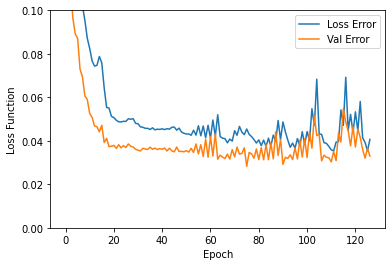

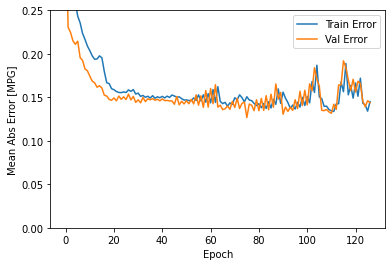

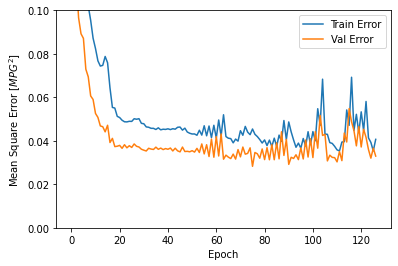

In [45]:
plot_history(history_lstm, 0, 0.1, 0.25, 0.1)

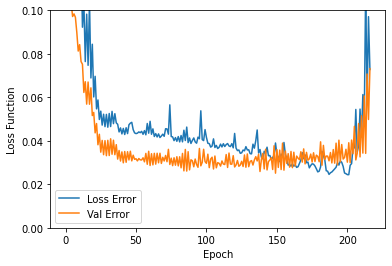

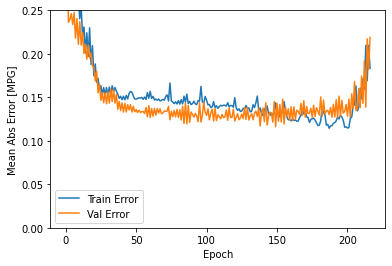

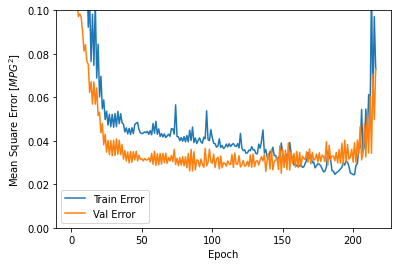

In [46]:
plot_history(history_lstm_ret_seq, 0, 0.1, 0.25, 0.1)

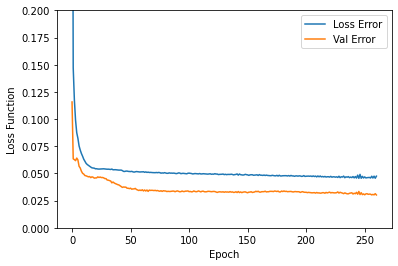

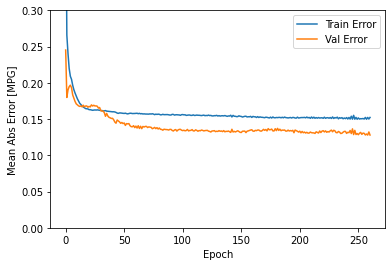

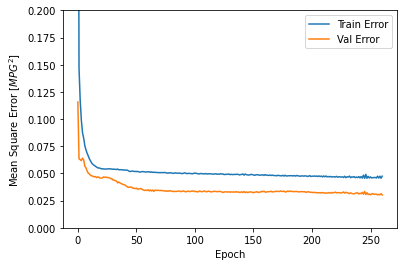

In [47]:
plot_history(history_cnn, 0, 0.2, 0.3, 0.2)

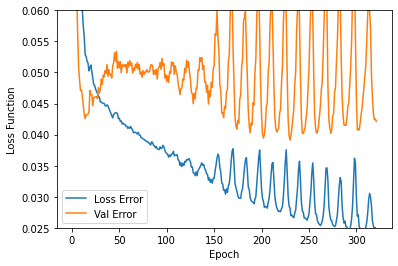

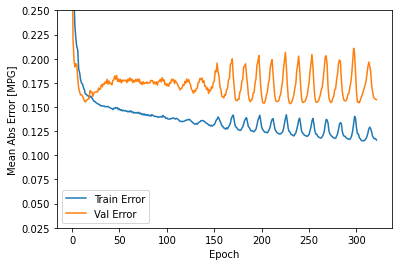

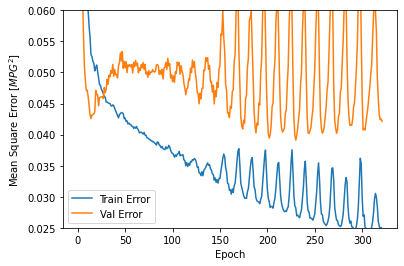

In [48]:
plot_history(history_cnn_relu, 0.025, 0.06, 0.25, 0.06)

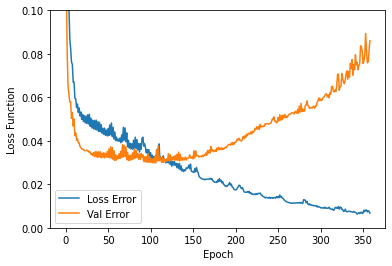

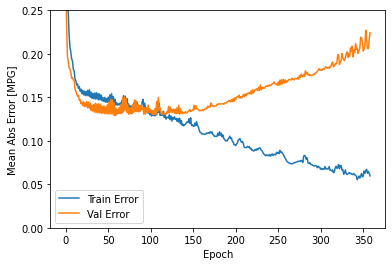

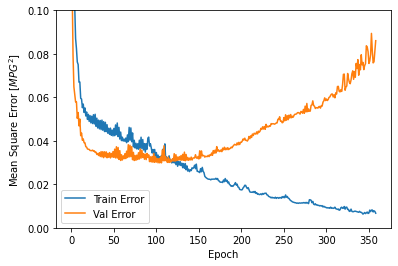

In [49]:
plot_history(history_gru, 0, 0.1, 0.25, 0.1)

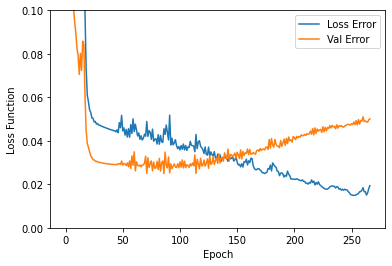

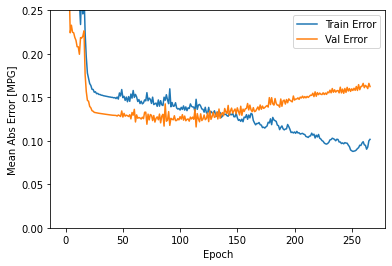

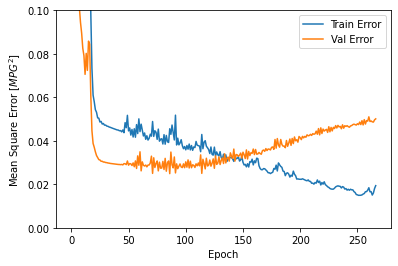

In [50]:
plot_history(history_lstm_unrestricted, 0, 0.1, 0.25, 0.1)

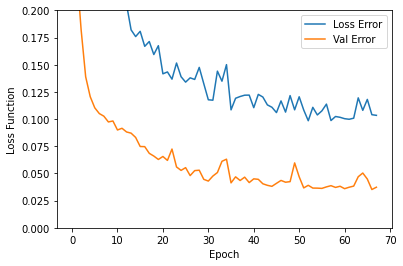

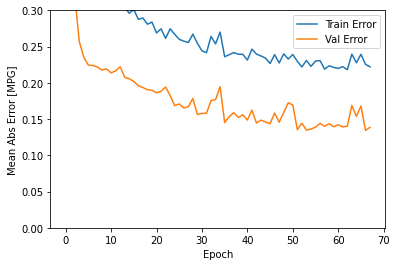

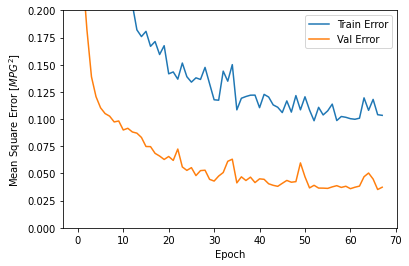

In [51]:
plot_history(history_lstm_dropout, 0, 0.2, 0.3, 0.2)

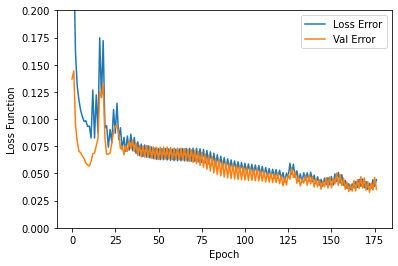

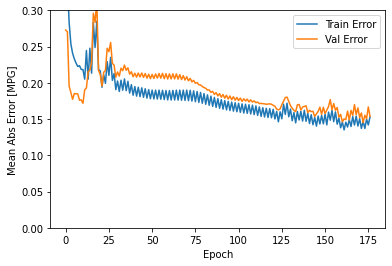

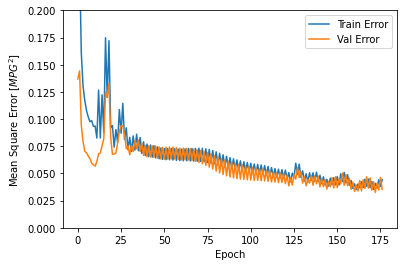

In [52]:
plot_history(history_lstm_go_bwd, 0, 0.2, 0.3, 0.2)

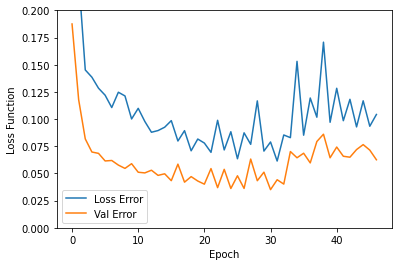

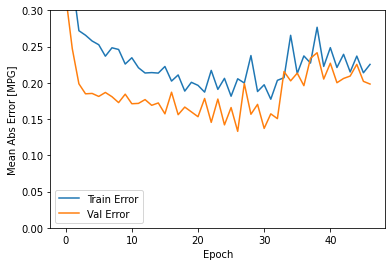

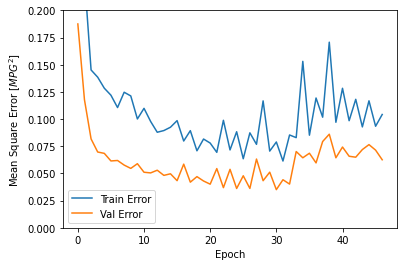

In [53]:
plot_history(history_lstm_bi, 0, 0.2, 0.3, 0.2)

In [54]:
y_pred_lstm = model_lstm.predict(x_test_norm)
y_pred_cnn = model_cnn.predict(x_test_norm)
y_pred_gru = model_gru.predict(x_test_norm)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)

In [55]:
y_pred_lstm_unrestricted = model_lstm_unrestricted.predict(x_test_norm)

In [56]:
y_pred_lstm_dropout = model_lstm_dropout.predict(x_test_norm)

In [57]:
y_pred_lstm_go_bwd = model_lstm_go_bwd.predict(x_test_norm)

In [58]:
y_pred_lstm_bi = model_lstm_bi.predict(x_test_norm)

In [59]:
def inverse_standarize_input(arr):
    arr = (arr * y_std) + y_mean
    return arr

In [60]:
y_pred_lstm = inverse_standarize_input(y_pred_lstm)
y_pred_cnn = inverse_standarize_input(y_pred_cnn)
y_pred_gru = inverse_standarize_input(y_pred_gru)
y_pred_lstm_ret_seq = inverse_standarize_input(y_pred_lstm_ret_seq)
y_pred_cnn_relu = inverse_standarize_input(y_pred_cnn_relu)
y_test = inverse_standarize_input(y_test_norm)

In [61]:
y_pred_lstm_unrestricted = inverse_standarize_input(y_pred_lstm_unrestricted)

In [62]:
y_pred_lstm_bi = inverse_standarize_input(y_pred_lstm_bi)

In [63]:
y_pred_lstm_dropout = inverse_standarize_input(y_pred_lstm_dropout)

In [64]:
y_pred_lstm_go_bwd = inverse_standarize_input(y_pred_lstm_go_bwd)

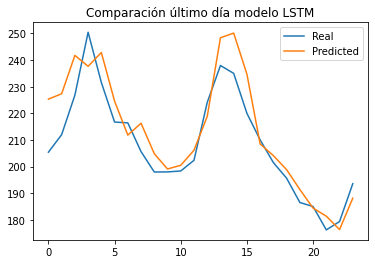

In [65]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

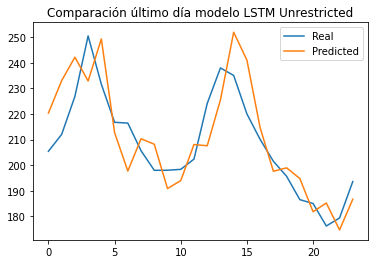

In [66]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_unrestricted[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Unrestricted")
plt.legend()

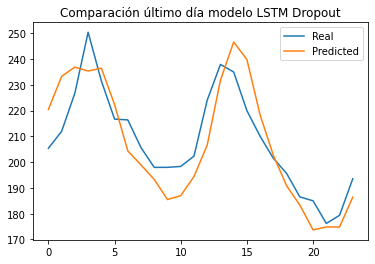

In [67]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_dropout[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Dropout")
plt.legend()

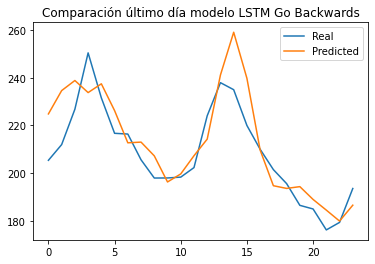

In [68]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_go_bwd[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Go Backwards")
plt.legend()

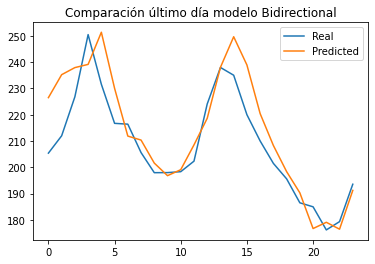

In [69]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_bi[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo Bidirectional")
plt.legend()

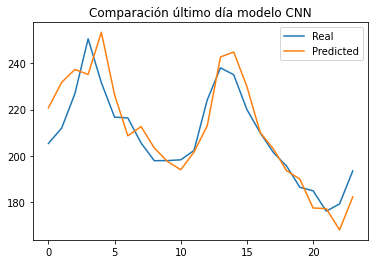

In [70]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

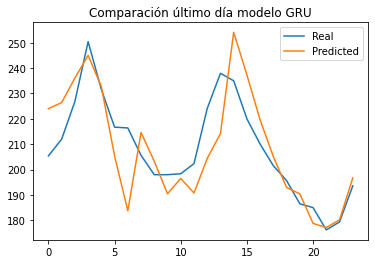

In [71]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

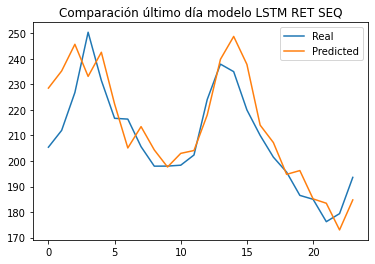

In [72]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_ret_seq[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

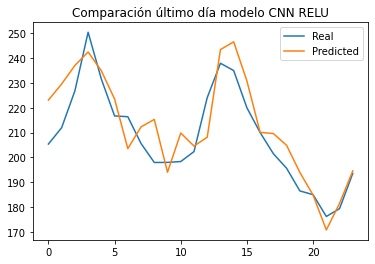

In [73]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn_relu[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [74]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)
rmse_lstm_unrestricted = np.sqrt(mean_squared_error(y_test, y_pred_lstm_unrestricted))
mae_lstm_unrestricted = mean_absolute_error(y_test, y_pred_lstm_unrestricted)
rmse_lstm_dropout = np.sqrt(mean_squared_error(y_test, y_pred_lstm_dropout))
mae_lstm_dropout = mean_absolute_error(y_test, y_pred_lstm_dropout)
rmse_lstm_go_bwd = np.sqrt(mean_squared_error(y_test, y_pred_lstm_go_bwd))
mae_lstm_go_bwd = mean_absolute_error(y_test, y_pred_lstm_go_bwd)
rmse_lstm_bi = np.sqrt(mean_squared_error(y_test, y_pred_lstm_bi))
mae_lstm_bi = mean_absolute_error(y_test, y_pred_lstm_bi)

In [75]:
print("RMSE LSTM BI: " + str(rmse_lstm_bi))
print("RMSE LSTM UNR: " + str(rmse_lstm_unrestricted))

RMSE LSTM BI: 16.523025157178203
RMSE LSTM UNR: 20.6063718178824


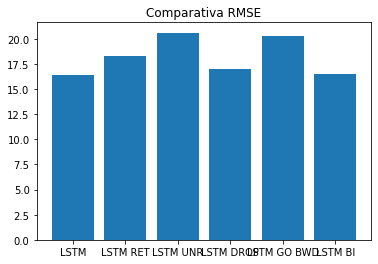

In [76]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI"]
y_axis = [rmse_lstm, rmse_lstm_ret_seq, rmse_lstm_unrestricted, rmse_lstm_dropout, rmse_lstm_go_bwd, rmse_lstm_bi]
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

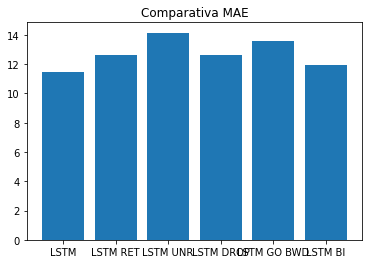

In [77]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI"]
y_axis = [mae_lstm, mae_lstm_ret_seq, mae_lstm_unrestricted, mae_lstm_dropout, mae_lstm_go_bwd, mae_lstm_bi]
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [78]:
model_lstm.save("normalized_multiple_input_2022_5/LSTM.h5")
model_cnn.save("normalized_multiple_input_2022_5/CNN.h5")
model_gru.save("normalized_multiple_input_2022_5/GRU.h5")
model_lstm_ret_seq.save("normalized_multiple_input_2022_5/LSTM_RET_SEQ.h5")
model_cnn_relu.save("normalized_multiple_input_2022_5/CNN_RELU.h5")
model_lstm_unrestricted.save("normalized_multiple_input_2022_5/LSTM_UNRESTRICTED.h5")
model_lstm_dropout.save("normalized_multiple_input_2022_5/LSTM_DROPOUT.h5")
model_lstm_go_bwd.save("normalized_multiple_input_2022_5/LSTM_GO_BWD.h5")
model_lstm_bi.save("normalized_multiple_input_2022_5/LSTM_BI.h5")